# Technical write-up+code

## Methods

In this section, I am going to predict whether a country has a high or low prevalence of eating disorders, based on the following features (educational, economial and geological factors) using a decision tree and random forest algorithm.

In general, a a decision Trees (DT) are a type of model used in machine learning that mimic human decision-making processes. Imagine you're trying to decide what to wear. You might look at the weather (a feature) and choose accordingly. A decision tree does something similar with data: it makes a series of choices based on the features to reach a conclusion, like deciding if an email is spam. It's like a flowchart – starting with a question about the data, it branches out until it reaches an answer.

Random Forests (RF) build on decision trees. If a decision tree is like a single advisor making a decision, a random forest is like a committee. It creates multiple decision trees, each with slightly different perspectives, and then combines their votes to make a final decision. This helps in getting a more balanced and less biased result, as it avoids over-relying on a single perspective.

## Data
The data I am using here is preprocessed (cleaned,feature selected and converted to categorical data) in the section `Naive Bayes' and saved as `mental_health_binarized.csv`in the Data_cleand folder. 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Low     0.5
High    0.5
Name: Eating disorders (%), dtype: float64


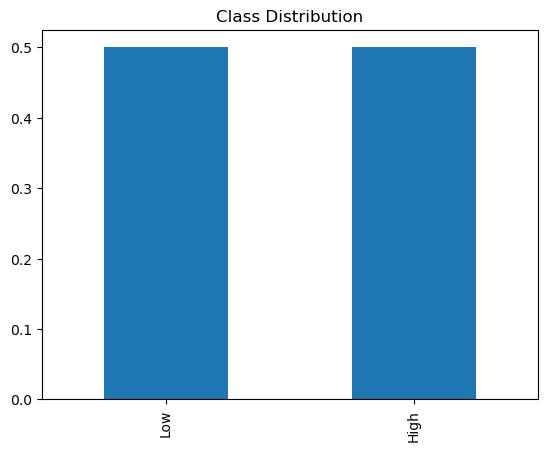

In [3]:
df_mental_health=pd.read_csv('./Data_cleaned/mental_health_binarized.csv')
# Compute the distribution of class labels whicih is eating disorder
df_mental_health.head()
class_distribution = df_mental_health['Eating disorders (%)'].value_counts(normalize=True)

# Output the distribution
print(class_distribution)

# Visualize the distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.show()

## Baseline model for comparison
To understand the accuracy of the model, I created a baseline model to compare it to. A baseline model in machine learning and data science serves as a simple, often basic reference point for comparing the performance of more complex models. 

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Prepare the data
X = df_mental_health.drop('Eating disorders (%)', axis=1)
y = df_mental_health['Eating disorders (%)']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit a random classifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

# Evaluate the classifier
y_pred = dummy.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.47      0.50      0.48       474
         Low       0.50      0.47      0.48       501

    accuracy                           0.48       975
   macro avg       0.48      0.48      0.48       975
weighted avg       0.48      0.48      0.48       975



## Model tuning
Decision Trees:

    Tree_depth  train_accuracy_score  test_accuracy_score
0            1              0.841930             0.827692
1            2              0.867847             0.856410
2            3              0.917372             0.902564
3            4              0.928406             0.916923
4            5              0.944573             0.937436
5            6              0.957147             0.949744
6            7              0.965615             0.951795
7            8              0.976905             0.964103
8            9              0.983577             0.967179
9           10              0.988709             0.966154
10          11              0.991789             0.968205
11          12              0.993841             0.969231
12          13              0.995638             0.971282
13          14              0.996407             0.974359
14          15              0.996664             0.973333
15          16              0.996664             0.972308
16          17

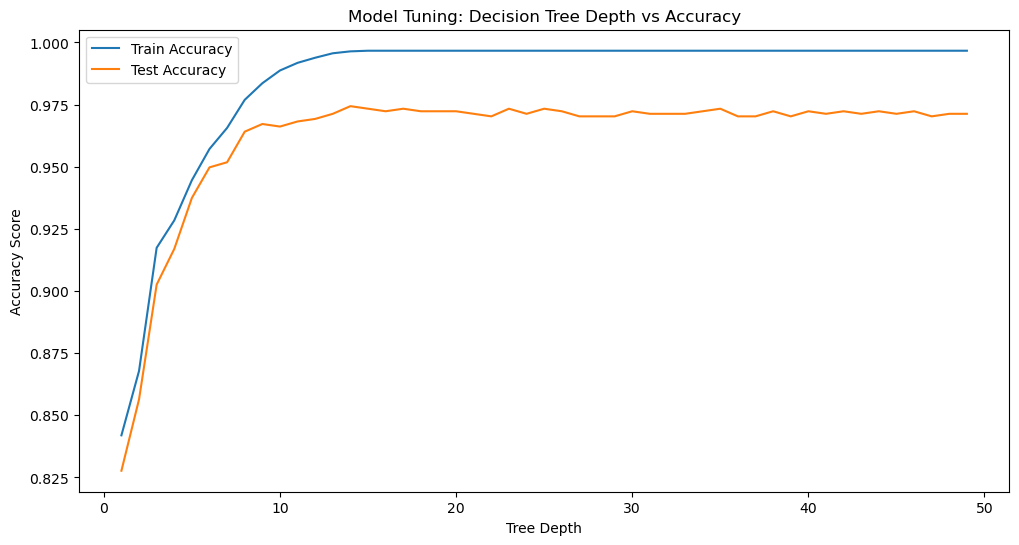

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load and preprocess your data
df_mental_health.columns
X = df_mental_health.drop(['Eating disorders (%)'],axis= 1) 
y = df_mental_health['Eating disorders (%)']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

test_results = []
train_results = []

for num_layer in range(1, 50):
    # Include TfidfVectorizer in the pipeline
    model = Pipeline([
        ('dt', DecisionTreeClassifier(max_depth=num_layer))
    ])
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    test_results.append([num_layer, accuracy_score(y_test, y_test_pred)])
    train_results.append([num_layer, accuracy_score(y_train, y_train_pred)])

# Create DataFrames for visualization
tuning_train_df = pd.DataFrame(train_results, columns=["Tree_depth", "train_accuracy_score"])
tuning_test_df = pd.DataFrame(test_results, columns=["Tree_depth", "test_accuracy_score"])
# print(tuning_train_df)
# print(tuning_test_df)
#merge two dataframes
tuning_df = pd.merge(tuning_train_df, tuning_test_df, on='Tree_depth')
print(tuning_df)
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(tuning_train_df['Tree_depth'], tuning_train_df['train_accuracy_score'], label='Train Accuracy')
plt.plot(tuning_test_df['Tree_depth'], tuning_test_df['test_accuracy_score'], label='Test Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy Score')
plt.title('Model Tuning: Decision Tree Depth vs Accuracy')
plt.legend()
plt.show()


The decesion tree has an accurcay of 0.996664 on the traning dataset and an accurcy of 0.973333 on the test dataset when the num_layer is set to 18. <br>

Random Forests:

In [6]:
from sklearn.tree import DecisionTreeClassifier

X = df_mental_health.drop(['Eating disorders (%)'],axis= 1) 
y = df_mental_health['Eating disorders (%)']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Set the parameters by cross-validation
tuned_parameters = {
    'rf__n_estimators': [10, 20, 30],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

# Create a new pipeline with a RandomForestClassifier
model_rf = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

# Use GridSearchCV to tune the model
clf = GridSearchCV(model_rf, tuned_parameters, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}


Random Forest training accuracy with best parameters: 99.67%
Random Forest testing accuracy with best parameters: 97.85%


[Text(0.5, 1.0, 'Accuracy of model for training vs test sets')]

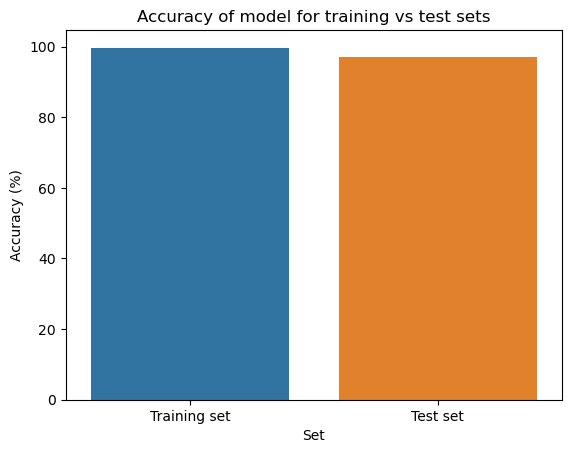

In [7]:
# Set the best parameters in the RandomForestClassifier
best_params_rf = {
    'n_estimators': 20, 
    'max_depth': None,
    'min_samples_leaf': 1, 
    'min_samples_split': 2, 
    'max_features': 'sqrt'
}

# Create the pipeline with TfidfVectorizer and RandomForestClassifier with the best parameters
model_rf = Pipeline([
    ('rf', RandomForestClassifier(**best_params_rf, random_state=42))
])

# Train the model with the best parameters on the training data
model_rf.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred_rf = model_rf.predict(X_train)
y_test_pred_rf = model_rf.predict(X_test)

# Calculate the accuracy scores for the training and test sets
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

# Print the accuracy scores
print(f"Random Forest training accuracy with best parameters: {train_accuracy_rf * 100:.2f}%")
print(f"Random Forest testing accuracy with best parameters: {test_accuracy_rf * 100:.2f}%")
# Plot
model_accuracies = pd.DataFrame({'Set':['Training set','Test set'], 'Accuracy (%)': [accuracy_score(y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred)*100]})
sns.barplot(data=model_accuracies, x="Set", y="Accuracy (%)").set(title = 'Accuracy of model for training vs test sets' )

In [8]:
# print(model.named_steps['dt'].classes_)
# # The first element is what '0' represents, and the second element is what '1' represents.

## Final results

Decision Trees:<br> 
The decesion tree has an accurcay of 0.996664 on the traning dataset and an accurcy of 0.973333 on the test dataset when the num_layer is set to 18. <br>
Initially, as the tree depth increases, there's an improvement in both training and testing accuracy. However, beyond a certain point, the increase in training accuracy does not translate to an improvement in testing accuracy. This suggests that the optimal tree depth for this model, where it balances learning from the training data without losing generalizability.

Random Forests:<br>
The random forest has an accurcay of 99.67% on the traning dataset and an accurcy of 97.85% on the test dataset.

And also while a high training accuracy score may seem positive at first glance, it can be indicative of overfitting when it is not accompanied by a corresponding high test accuracy.

## Evaluation
### Confusion matrix
#### Decision Trees
- Traning dataset

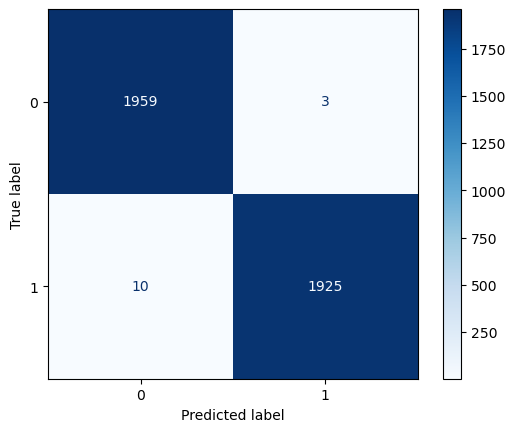

In [9]:
# confusion matrix(test set)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm1 = confusion_matrix(y_train, model.predict(X_train))
# Plot using ConfusionMatrixDisplay
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap="Blues")

- Test dataset

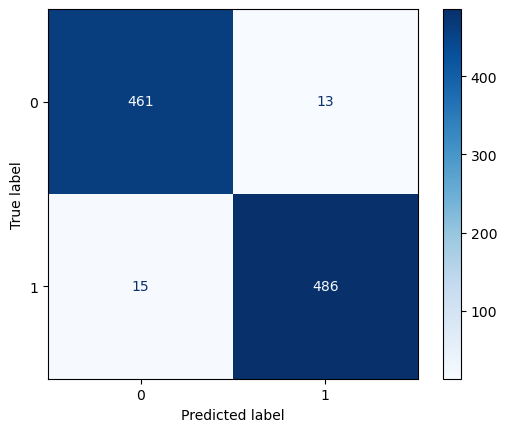

In [10]:
# confusion matrix(test set)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm1 = confusion_matrix(y_test, model.predict(X_test))
# Plot using ConfusionMatrixDisplay
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap="Blues")

### Visualizing the decision tree

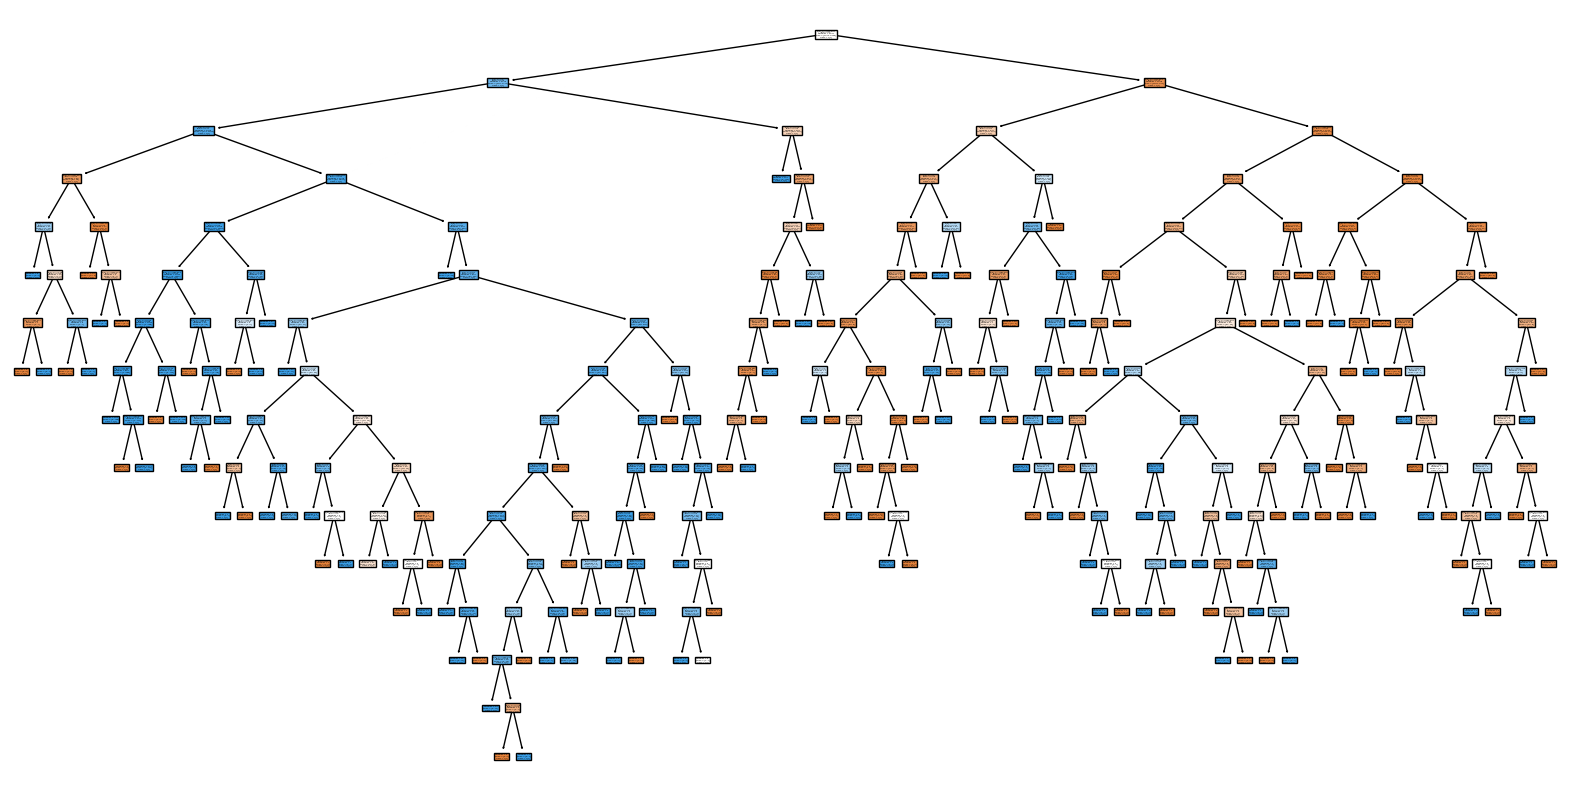

In [11]:
#decesion tree visualization
from sklearn.tree import plot_tree

# Fit the model with desired tree depth(3)
desired_depth = 18
model = Pipeline([
    ('dt', DecisionTreeClassifier(max_depth=desired_depth))
])
model.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(model.named_steps['dt'], filled=True, class_names=True)
plt.show()

#### Random Forests
- Traning dataset

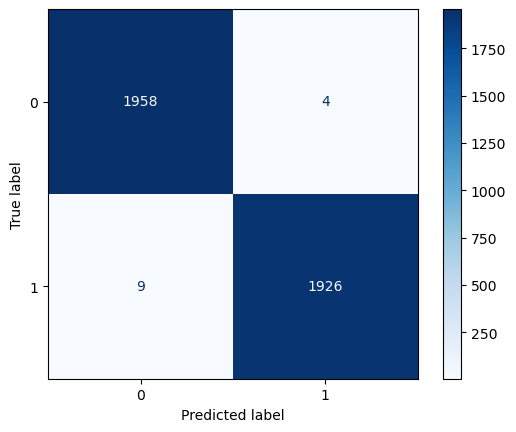

In [12]:
# confusion matrix(test set)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm1 = confusion_matrix(y_train, model_rf.predict(X_train))
# Plot using ConfusionMatrixDisplay
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap="Blues")

- Test dataset

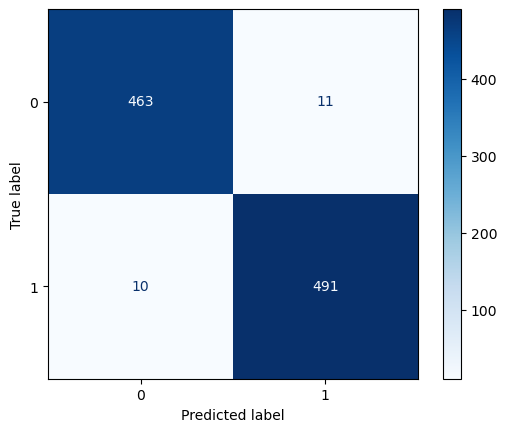

In [13]:
# confusion matrix(test set)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm1 = confusion_matrix(y_test, model_rf.predict(X_test))
# Plot using ConfusionMatrixDisplay
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap="Blues")

# Conclusions

In conclusion, I think this decision tree model and random forest model are  high quality models because they have high accuracy scores for both training and test sets. And The random forest has an accurcay of 99.67% on the traning dataset and an accurcy of 97.85% on the test dataset, which is higher than the decision tree model.

#### Relationship of Features to Eating Disorders

This study employed a Random Forest algorithm and decesion trees to predict the prevalence of eating disorders based on a set of educational, socio-economic and geographical features. The confusion matrix results indicate a high level of accuracy, suggesting that the chosen features—average learning years of school, GDP per capita, total GDP, and continent significant predictive power.

Educational attainment, as measured by average learning years of school, may influence an individual's understanding of nutrition and body image, potentially affecting eating disorder prevalence. Higher education levels could correlate with greater awareness and early detection of eating disorders, impacting reported prevalence rates.

GDP per capita serves as a proxy for the economic status of individuals within a country. Higher economic status may lead to greater access to a variety of foods and healthcare services, but it may also bring increased exposure to Western beauty standards and diet culture, which have been linked to eating disorders.

The income level reflects the country's overall resources, which may determine the extent to which it can fund healthcare infrastructure, including mental health services. Countries with higher income might have more comprehensive healthcare systems capable of diagnosing and reporting eating disorders more accurately.

The inclusion of 'continent' as a feature acknowledges the cultural and geographica diversity that impacts the prevalence of eating disorders. Variations in diet, societal norms, and healthcare accessibility across different continents could significantly influence these rates.

#### Model Application in a Real-World context

The model's predictive capability could be instrumental for public health officials and policymakers. By identifying regions with a higher prevalence of eating disorders, targeted interventions can be designed, and resources can be allocated efficiently to where they are needed most. It could also aid in developing tailored prevention programs that consider local cultural and economic contexts.